## CALTRANS: Burn area mapping and visualization
- BAER burn severity

In [365]:
# Load libraries
import os, glob, datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None) # View entire dataframe
pd.set_option('display.max_columns', None) # View entire dataframe


# Geospatial processing
import geopandas as gpd
import rasterio

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
plt.rcdefaults()
import seaborn as sns

In [2]:
# Load paths
BASEPATH = "/Users/minho/Desktop/Projects/CALTRANS/data"
data_path = os.path.join(BASEPATH, 'baer_all')

def find_files(directory, term):
    shp_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(term):
                shp_files.append(os.path.join(root, file))
    return shp_files

# Return burn areas with "bndy.shp" suffix
shp_files = find_files(os.path.join(BASEPATH), "bndy.shp")
refl_files = find_files(os.path.join(BASEPATH), "refl.tif")

barc4_files = find_files(data_path, "barc4.tif")
barc256_files = find_files(data_path, "barc256.tif")

In [3]:
# Cali state bnd
cali_bnd = gpd.read_file("/Users/minho/Desktop/Projects/CALTRANS/data/CA_State_TIGER2016.shp").to_crs('EPSG:4326')
extents = cali_bnd.total_bounds

In [4]:
data_list = sorted(os.listdir(data_path))
data_list = data_list[1:] # Remove .DS_Store

#### Visualize all fires

In [5]:
# Isolate state codes (2 first letters)
state_list = [word[:2].lower() for word in data_list]
num, counts = np.unique(state_list, return_counts=True)

# Compute relative proportions
_counts = counts / np.sum(counts)

state_list_dict = sorted(list(zip(counts, num, _counts))) # Sort by ascending
counts, num, _counts = zip(*state_list_dict) # Unzip (Notice reversed order)

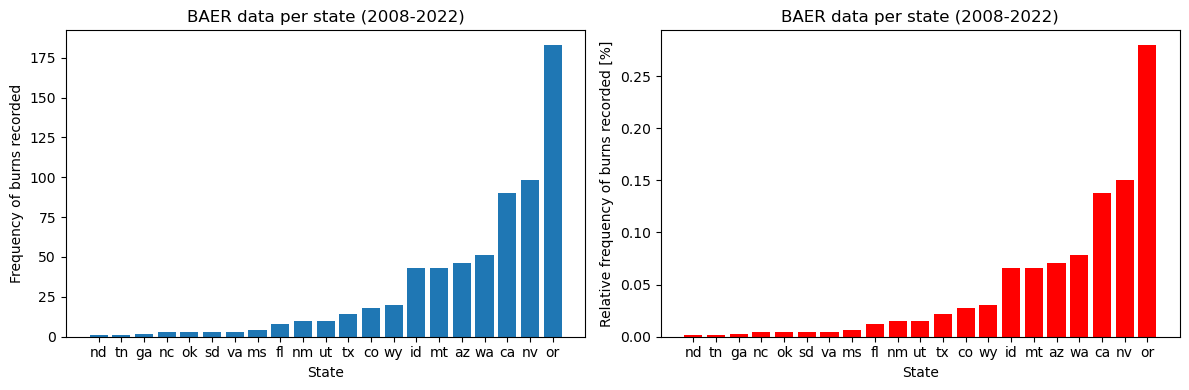

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].bar(num, counts)
ax[0].set_title("BAER data per state (2008-2022)")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Frequency of burns recorded")

ax[1].bar(num, _counts, color='red')
ax[1].set_title("BAER data per state (2008-2022)")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Relative frequency of burns recorded [%]")

plt.tight_layout()
plt.show()

In [7]:
print("Total number of BAER burn scars (2008-2022): {} fires".format(np.sum(counts)))

Total number of BAER burn scars (2008-2022): 654 fires


#### DF

In [8]:
# Create DF of all inputs
df = pd.DataFrame({'path':[],
                   'state':[],
                   'shp':[],
                   'barc4':[],
                   'barc256':[],
                   'refl1':[],
                   'refl2':[]})

path_list,shp_list,barc4_list,barc256_list,refl1_list,refl2_list = [],[],[],[],[],[]

for dir in data_list:
    dir_path = os.path.join(data_path, dir)
    shp_files = glob.glob(os.path.join(dir_path, "*bndy*.shp"))
    barc4 = glob.glob(os.path.join(dir_path, '*barc4*.tif'))
    barc256 = glob.glob(os.path.join(dir_path, '*barc256*.tif'))
    refl = glob.glob(os.path.join(dir_path, '*refl*.tif'))

    path_list.append(dir)
    
    if shp_files is []: shp_list.append(0);
    else: shp_list.append(shp_files[0])
    
    if barc4 == []: barc4_list.append(0);
    else: barc4_list.append(barc4[0]);

    if barc256 == []: barc256_list.append(0);
    else: barc256_list.append(barc256[0]);

    if len(refl) >= 2: # For cases where there are more than 2 images (ie. pre & post)
        refl1_list.append(refl[0])
        refl2_list.append(refl[1])
    else:
        refl1_list.append(refl)
        refl2_list.append(0)
        
# Create DF
df['path'] = path_list
df['state'] = state_list
df['shp'] = shp_list
df['barc4'] = barc4_list
df['barc256'] = barc256_list
df['refl1'] = refl1_list
df['refl2'] = refl2_list

#### PLOT

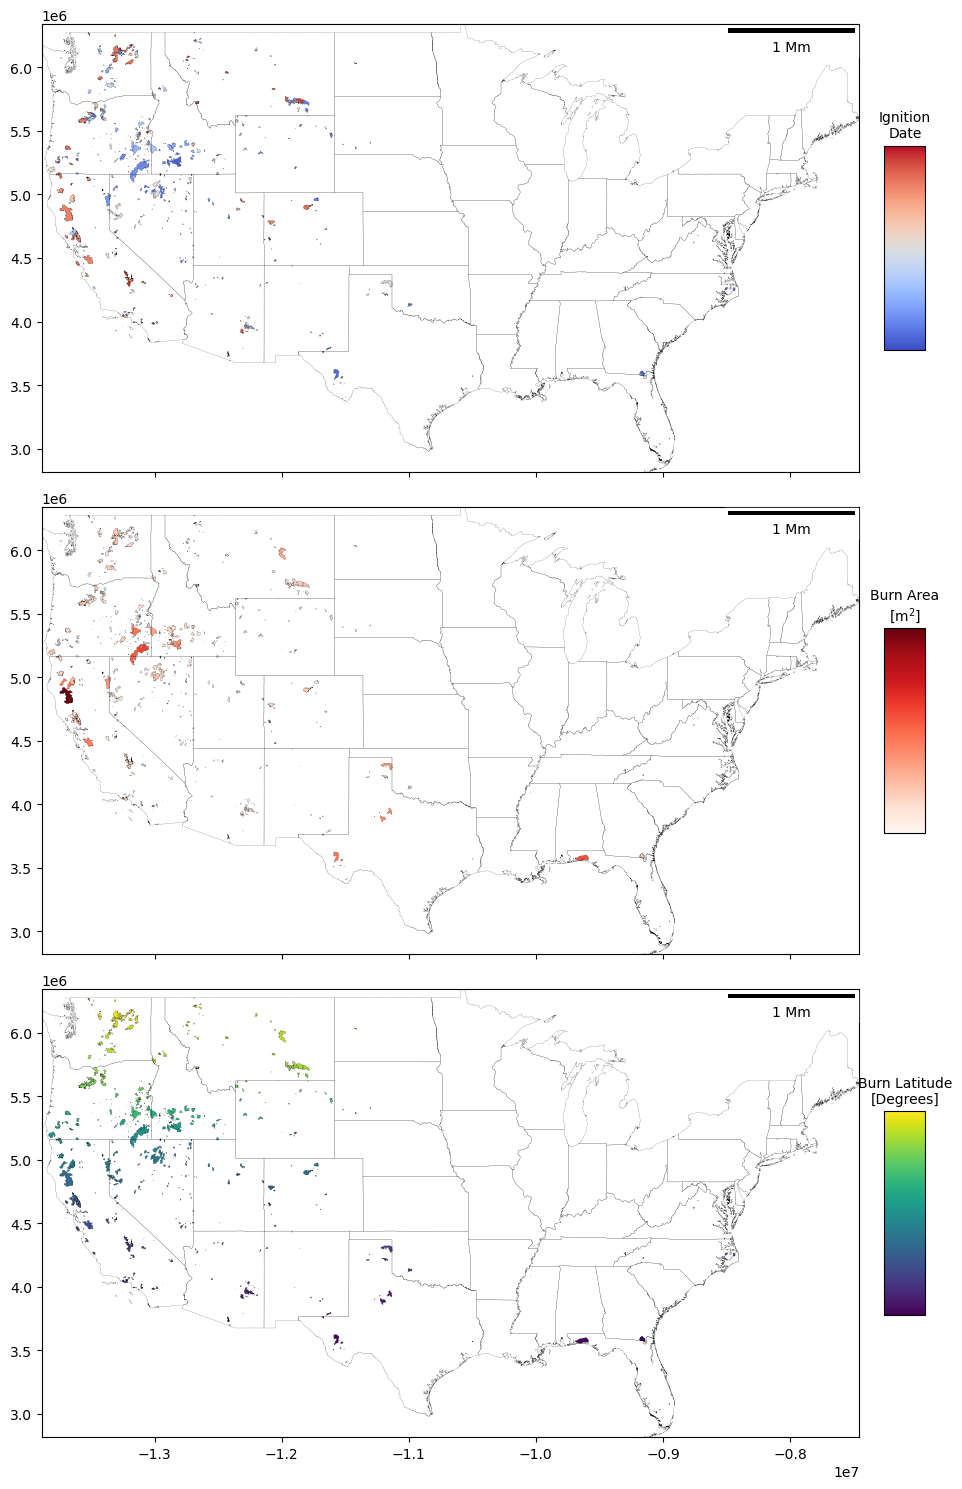

In [9]:
full_list = []

for shp in df['shp']:
    _f = gpd.read_file(shp).to_crs('EPSG:3857')
    full_list.append(_f)
f = pd.concat(full_list).reset_index(drop=True)

# Add labels for individual plots
f_subset = f[['Ig_Date', 'BurnBndAc', 'BurnBndLat', 'geometry']]

columns = ['Ig_Date', 'BurnBndAc', 'BurnBndLat']
colormaps = ['coolwarm', 'Reds', 'viridis']
labels = ['Ignition\nDate', 'Burn Area\n[m$^2$]', 'Burn Latitude\n[Degrees]']

# Define the number of subplots and their arrangement
rows, cols = (3,1)

# Create the subplots using a for loop
fig, axs = plt.subplots(rows, cols, figsize=(25, 15), sharex=True, sharey=True)
# Flatten the axs array if needed
if rows > 1:
    axs = axs.flatten()

# Iterate over the subplots and plot the data
for i, ax in enumerate(axs):

    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", aspect=5, pad=0.25)
    sm = plt.cm.ScalarMappable(cmap=colormaps[i])
    
    f_subset.plot(ax=ax, column=columns[i], cmap=colormaps[i], cax=cax, edgecolor='k', linewidth=0.1, legend=False)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.ax.set_title(labels[i], size=10)
    cbar.set_ticks([])
    # cbar.set_ticklabels([str(f_subset[columns[i]].astype(float).min()), str(f_subset[columns[i]].astype(float).max())])

    # California state boundary
    state_bnd = gpd.read_file('/Users/minho/Desktop/Projects/CALTRANS/data/US_State_Boundaries.shp').to_crs("EPSG:3857")
    extents = state_bnd.total_bounds
    state_bnd.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.1)

    # Set the plot limits based on the extents
    ax.set_xlim(extents[0], extents[2])
    ax.set_ylim(extents[1], extents[3])

    # Add scalebar
    scalebar = ScaleBar(1, units='m', location='upper right')  # Adjust the scale as per your needs
    ax.add_artist(scalebar)
    
plt.tight_layout()
# plt.savefig('BAER_plots_severity.png', bbox_inches='tight', dpi=300)

/var/folders/4q/2ngj48zn1b9cn0bd_kz6gg8c0000gn/T/ipykernel_12051/2545218764.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  empty_list = empty_barc4.append(empty_barc256).append(empty_refl2)
/var/folders/4q/2ngj48zn1b9cn0bd_kz6gg8c0000gn/T/ipykernel_12051/2545218764.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  empty_list = empty_barc4.append(empty_barc256).append(empty_refl2)


IndexError: list index out of range

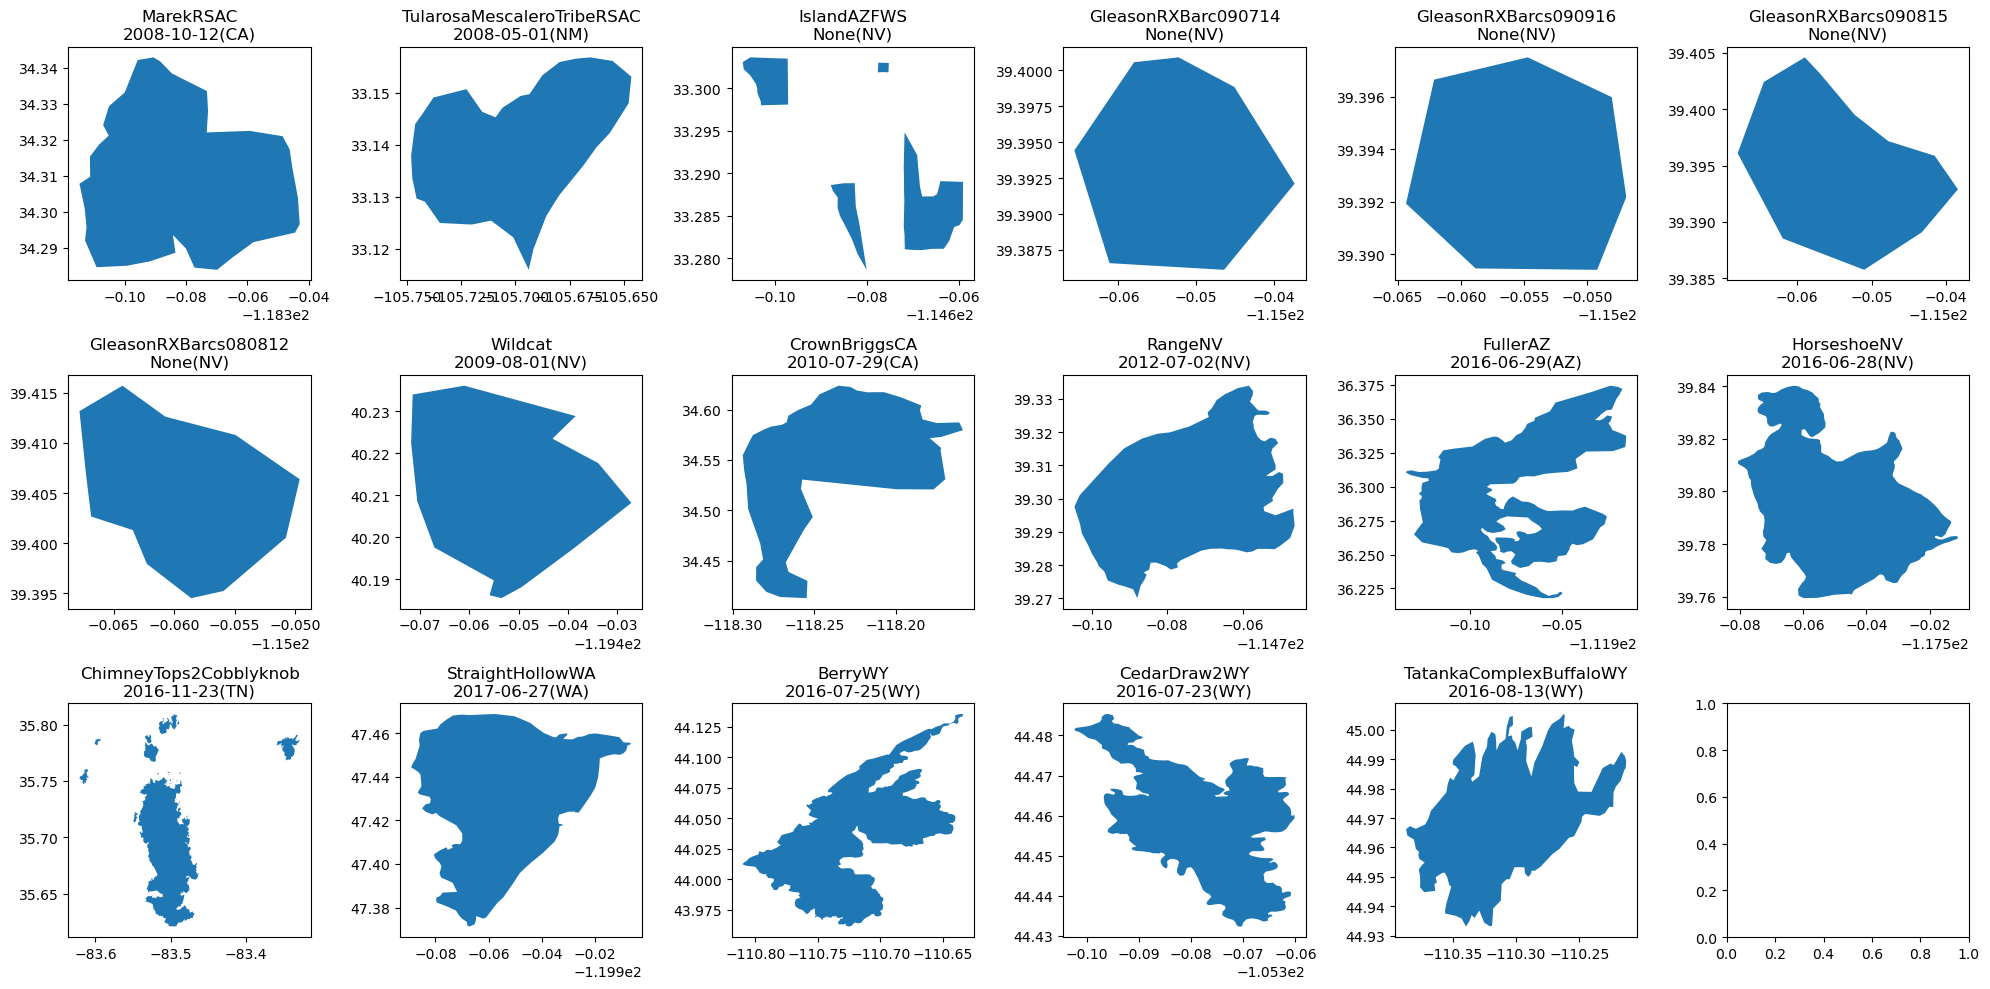

In [16]:
# Empty
empty_barc4 = df['path'].iloc[np.where(df['barc4'] == 0)]
empty_barc256 = df['path'].iloc[np.where(df['barc256'] == 0)]
# empty_refl1 = df['path'].iloc[np.where(df['refl1'] == 0)]
empty_refl2 = df['path'].iloc[np.where(df['refl2'] == 0)]

empty_list = empty_barc4.append(empty_barc256).append(empty_refl2)

# Create shapefile list of all missing datasets
f_list = []
for idx in empty_list.index:
    _f = gpd.read_file(df.iloc[idx]['shp']).to_crs('EPSG:4326')
    f_list.append(_f)
f = pd.concat(f_list).reset_index(drop=True)

# Plot
nrow = 3; ncol = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(20,10))

# Plotting 17 errors
counter = 0
for i in range(nrow):
    for j in range(ncol):
        
        f_list[counter].plot(ax=ax[i,j])
        ax[i,j].set_title(f_list[counter]['Incid_Name'][0] + '\n' + str(f_list[counter]['Ig_Date'][0]) + '(' + f_list[counter]['Event_ID'][0][:2] + ')')
        counter += 1

        ax[i,j].set_aspect("auto")
        plt.tight_layout()

#### Characterizing burn severity data

In [1]:
# Load libraries
import os, glob, datetime, tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None) # View entire dataframe
pd.set_option('display.max_columns', None) # View entire dataframe


# Geospatial processing
import geopandas as gpd
import rasterio

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
plt.rcdefaults()
import seaborn as sns

In [2]:
# # Select all fires in California
# f = pd.concat(full_list).reset_index(drop=True)
# cali_list = f[(f['Event_ID'].str[0:2] == 'CA')].reset_index(drop=True)

In [3]:
def find_files(directory, term):
    shp_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(term):
                shp_files.append(os.path.join(root, file))
    return shp_files

def load_img(pre_img, post_img, mode1, mode2):

    meta1 = rasterio.open(pre_img).meta
    meta2 = rasterio.open(pre_img).meta    
    
    # Load pre-fire image    
    if mode1 == 1: # Sentinel-2
        green, red, nir, swir = rasterio.open(pre_img, 'r').read([1,2,3,6])
    elif mode1 == 2: # Landsat-8
        green, red, nir, swir = rasterio.open(pre_img, 'r').read([3,4,5,6])
    elif mode1 == 3: # Landsat-7
        green, red, nir, swir = rasterio.open(pre_img, 'r').read([3,4,5,6])
    elif mode1 == 4: # Landsat-5
        green, red, nir, swir = rasterio.open(pre_img, 'r').read([3,4,5,6])

    # Load post-fire image    
    if mode2 == 1: # Sentinel-2
        _green, _red, _nir, _swir = rasterio.open(post_img, 'r').read([1,2,3,6])
    elif mode2 == 2: # Landsat-8
        _green, _red, _nir, _swir = rasterio.open(post_img, 'r').read([3,4,5,6])
    elif mode2 == 3: # Landsat-7
        _green, _red, _nir, _swir = rasterio.open(post_img, 'r').read([2,3,4,6])
    elif mode2 == 4: # Landsat-5
        _green, _red, _nir, _swir = rasterio.open(post_img, 'r').read([3,4,5,6]) 

    return green, red, nir, swir, _green, _red, _nir, _swir, meta1, meta2

def compute_nbr(b7,b4,bb7,bb4):
    # Compute NBR
    nbr0 = (b7 - b4) / ((b7 + b4) + 1e-6)
    nbr1 = (bb7 - bb4) / ((bb7 + bb4)  + 1e-6)

    nbr0[nbr0 == np.inf] = np.nan
    nbr1[nbr1 == np.inf] = np.nan

    # Compute dNBR
    dnbr = nbr0 - nbr1
    dnbr[dnbr < -2] = np.nan
    dnbr[dnbr > 2] = np.nan

    return nbr0, nbr1, dnbr

def compute_ndvi(b4,b3,bb4,bb3):
    # Compute NDVI
    ndvi0 = (b4 - b3) / ((b4 + b3) + 1e-6)
    ndvi1 = (bb4 - bb3) / ((bb4 + bb3)  + 1e-6)

    ndvi0[ndvi0 == np.inf] = np.nan
    ndvi1[ndvi1 == np.inf] = np.nan

    # Compute dNBR
    dndvi = ndvi1 - ndvi0
    dndvi[dndvi < -1] = np.nan
    dndvi[dndvi > 1] = np.nan
    
    return ndvi0, ndvi1, dndvi

In [332]:
BASEPATH = "/Users/minho/Desktop/Projects/CALTRANS/data"
state = 'baer_cali'

file_list = os.listdir(os.path.join(BASEPATH, state))
if '.DS_Store' in file_list:
    file_list.remove('.DS_Store')

# Set data containers
dndvi_list, dnbr_list, barc_list = [],[],[]

    
# Set index
for i in tqdm.tqdm(range(len(file_list))):
    
    # Load images
    img_files = sorted(glob.glob(os.path.join(BASEPATH, state, file_list[i], '*refl*.tif')))
    dnbrs = sorted(glob.glob(os.path.join(BASEPATH, state, file_list[i], '*_dnbr.tif')))    
    barc4_files = glob.glob(os.path.join(BASEPATH, state, file_list[i], '*barc4*.tif'))

    # Identify sensor
    sensor1 = img_files[0].split('/')[-1].split('_refl.tif')[0].split('_')[-1]
    if sensor1 == "S2A" or sensor1 == "S2B" or sensor1 == "S2": mode1=1
    elif sensor1 == "L8" or sensor2=="l8": mode1=2; 
    elif sensor1 == "L7" or sensor2=="l7": mode1=3; 
    elif sensor1 == "L5" or sensor2=="l5": mode1=4

    sensor2 = img_files[1].split('/')[-1].split('_refl.tif')[0].split('_')[-1]
    if sensor2 == "S2A" or sensor2 == "S2B" or sensor2 == "S2": mode2=1
    elif sensor2 == "L8" or sensor2=="l8": mode2=2; 
    elif sensor2 == "L7" or sensor2=="l7": mode2=3; 
    elif sensor2 == "L5" or sensor2=="l5": mode2=4    

    # print('Pre-fire:', sensor1, '-->',mode1)
    # print('Post-fire:', sensor2, '-->',mode2)

    # Load image
    green, red, nir, swir, _green, _red, _nir, _swir, m1, m2 = load_img(img_files[0], img_files[1], mode1, mode2)
    barc4 = rasterio.open(barc4_files[0]).read([1])[0]
    
    barc4[barc4==5] = 0
    barc4[barc4==6] = 0
    barc4[barc4==255] = 0
    
    # Compute NBR
    nbr0, nbr1, dnbr = compute_nbr(swir, nir, _swir, _nir)
    # Compute NDVI
    ndvi0, ndvi1, dndvi = compute_ndvi(nir, red, _nir, _red)

    dndvi_list.append(ndvi0 - ndvi1)
    dnbr_list.append(nbr0 - nbr1)    
    barc_list.append(barc4)

100%|███████████████████████████████████████████| 84/84 [00:58<00:00,  1.44it/s]


#### ML

In [358]:
import numpy as np

# Assuming you have three lists of differently-sized images: image_list1, image_list2, image_list3
# Assuming you have a label image: label_image

# Convert the image lists and label image to numpy arrays
image_array1 = dndvi_list
image_array2 = dnbr_list
label_array = barc_list

# Get the unique class values from the label image
classes = range(5)

# Define the number of points to sample per class
n_points = 2000

s1_p, s2_p = [], []
labels = []

for i in range(len(label_array)):
    
    # Locate sample points
    for cls in np.unique(label_array[i]):
        clas = np.argwhere(label_array[i] == cls)
        samples = random.choices(clas, k=n_points)
        
        for j in range(len(samples)):
            s1_p.append(dndvi_list[i][samples[j][0]][samples[j][1]])
            s2_p.append(dnbr_list[i][samples[j][0]][samples[j][1]])
            labels.append(label_array[i][samples[j][0]][samples[j][1]])

In [359]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=uint8),
 array([128000, 168000, 168000, 168000, 132000]))

In [360]:
X = np.stack((s1_p, s2_p))
X = np.rollaxis(X,1,0)
y = labels

In [361]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)


In [362]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

#Create a Classifier
clf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [363]:
y_pred=clf.predict(X_test)

In [364]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))

cr = classification_report(y_test, y_pred)
print(cr)


Accuracy: 0.5566099476439791
              precision    recall  f1-score   support

           0       0.53      0.46      0.50     76909
           1       0.47      0.49      0.48    100731
           2       0.50      0.50      0.50    100641
           3       0.56      0.56      0.56    100773
           4       0.74      0.80      0.77     79346

    accuracy                           0.56    458400
   macro avg       0.56      0.56      0.56    458400
weighted avg       0.55      0.56      0.55    458400



In [366]:
from xgboost import XGBRegressor

/Users/minho/opt/anaconda3/envs/cell2fire/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ["dlopen(/Users/minho/opt/anaconda3/envs/cell2fire/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'\n  Referenced from: '/Users/minho/opt/anaconda3/envs/cell2fire/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib'\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]
